In [87]:
#William Connor Parham
#Project 2 - Dimensionality Reduction And Unsupervised Learning
#Cosc 522
#Dr. Hairong Qi
#10/17/2023

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import struct
import random
import seaborn as sns
from array import array
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from os.path import join
from imageio import imread

In [88]:
#USE MNIST DATA LOADER FROM KAGGLE DATASET
#
# MNIST Data Loader Class
#

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

In [89]:
#Load images from MNIST
input_path = './MNIST/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

**Task 1-1 Standardize Images**

In [90]:
#Task 1-1 - Standardize Images
nX = []
x = np.array(x_train)
stdev = np.std(x, axis=(0,1))
mean = np.mean(x, axis=(0,1))
for image in x_train:
    col = (image-mean)/stdev
    col = np.nan_to_num(col, nan=0)
    nX.append(col)

tX = []
d = np.array(x_test)
stdev = np.std(d, axis=(0,1))
mean = np.mean(d, axis=(0,1))
for image in x_test:
    col = (image-mean)/stdev
    col = np.nan_to_num(col, nan=0)
    tX.append(col)

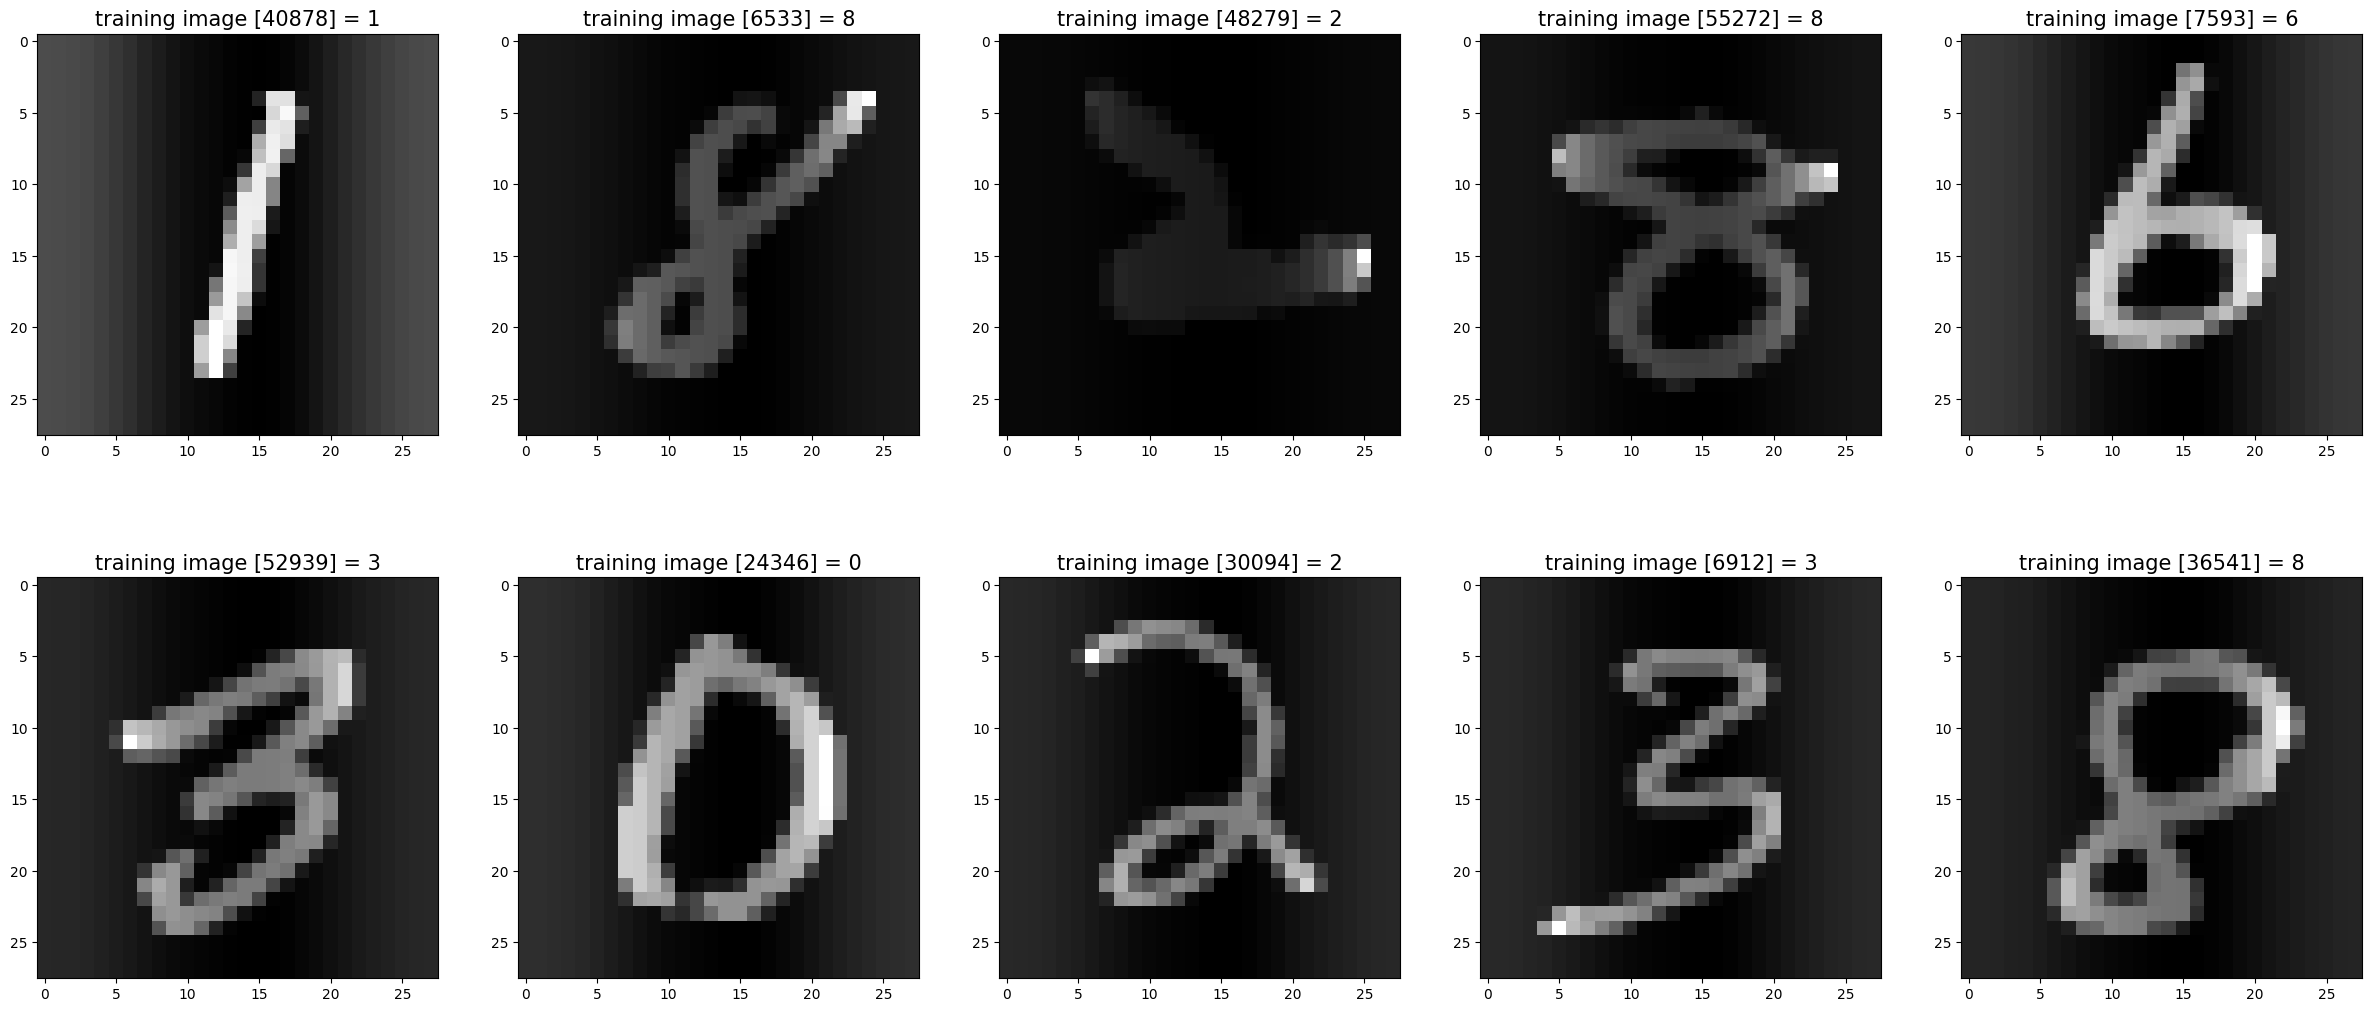

In [ ]:
#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(nX[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

show_images(images_2_show, titles_2_show)

**Task 1-2 FLD Projection and Visualization**

In [ ]:
nx_w_class = {'images': nX,
              'labels': y_train}

nx_w_class = pd.DataFrame(nx_w_class)
# nx_w_class = nx_w_class.sort_values(by='labels')
means_labels = nx_w_class.groupby('labels')['images'].apply(lambda x: np.mean(np.array(x.tolist()), axis=0))

#Find the Global Mean for FLD Calculation
m = np.mean(np.array(nx_w_class['images'].tolist()), axis=0)

#Find Class Wise Scatter Matrices for FLD Calculation using Within-Between Scatters
scatter_matrices = []
outer_matrices = []
for label, mean in means_labels.items():
    image_group = np.array(nx_w_class[nx_w_class['labels'] == label]['images'].tolist())
    
    # smatrix = np.zeros((28, 28))
    outers = np.zeros((784,784))
    for image in image_group:
        #k = np.dot((image-mean), (image-mean).T)
        # smatrix += k
        z = np.outer((image - mean), (image - mean).T)
        outers += z

    # scatter_matrices.append(smatrix)
    outer_matrices.append(outers)

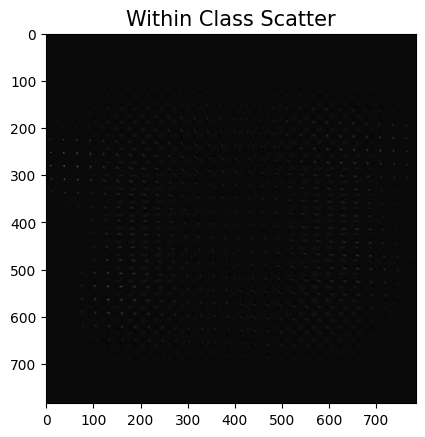

In [ ]:
# #Calculate the Within Scatter matrix
within_scatter = np.empty((784,784))
for item in outer_matrices:
    within_scatter += item 


#sw matrix code
title_text = 'Within Class Scatter'
plt.subplot(1, 1, 1)
plt.imshow(within_scatter, cmap=plt.cm.gray)
if (title_text != ''):
    plt.title(title_text, fontsize=15)
plt.show()



rank:  9


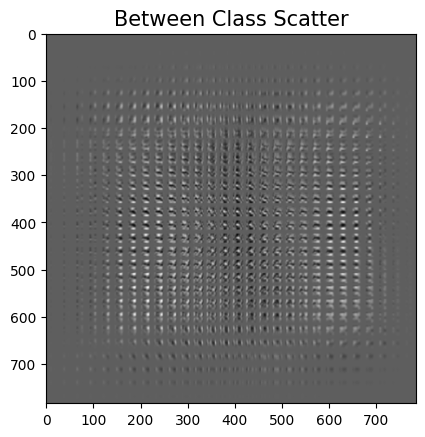

In [ ]:
#Calculate the Between Scatter Matrix
between_scatter = np.empty((784,784))
for label, mk in means_labels.items():
    nk = len(nx_w_class[nx_w_class['labels'] == label])
    between_scatter += nk * np.outer((mk - m), (mk - m).T)

rank = np.linalg.matrix_rank(between_scatter)
print('rank: ', rank)

#sw matrix code
title_text = 'Between Class Scatter'
plt.subplot(1, 1, 1)
plt.imshow(between_scatter, cmap=plt.cm.gray)
if (title_text != ''):
    plt.title(title_text, fontsize=15)
plt.show()


In [ ]:
#Perform Eigenvalue Decomposition
print(within_scatter.shape)
print(between_scatter.shape)

eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.pinv(within_scatter), between_scatter))

print('shape of eigenvector[0]: ', eigenvectors[0].shape)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

projection_matrix = eigenvectors[:, :249]

npx_train = np.array(x_train)
npx_test = np.array(x_test)
fnX = [array.flatten() for array in npx_train]  #maybe dont reassign nx here
ftX = [array.flatten() for array in npx_test]

projected_data = np.dot(fnX, projection_matrix)

projected_test_data = np.dot(ftX, projection_matrix)

reals = [np.real(array) for array in projected_data]
test_reals = [np.real(array) for array in projected_test_data]
reals = pd.DataFrame(reals)
test_reals = pd.DataFrame(test_reals)

real_labels = pd.DataFrame(np.array(y_train))
real_test_labels = pd.DataFrame(np.array(y_test))

tsne = TSNE(n_components=2, verbose=1, random_state=42)
z = tsne.fit_transform(reals)
fX = z
ftX = tsne.fit_transform(test_reals)

df = pd.DataFrame()
df["y"] = real_labels
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

(784, 784)
(784, 784)
shape of eigenvector[0]:  (784,)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.060s...
[t-SNE] Computed neighbors for 60000 samples in 15.660s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 

In [ ]:
fX = z

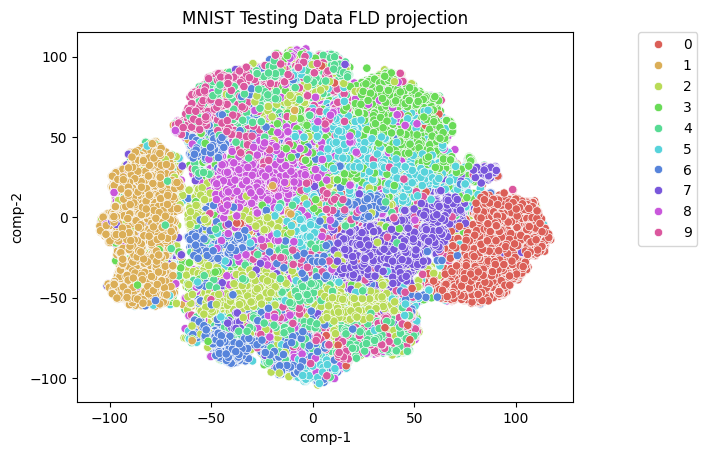

In [ ]:
g = sns.scatterplot(x='comp-1', y='comp-2', hue=df.y.tolist(), palette=sns.color_palette('hls', 10),
                    data=df).set(title="MNIST Testing Data FLD projection")
plt.legend(bbox_to_anchor=(1.25,1), borderaxespad=0)
plt.show()

**Task 1-3 PCA Projection And Visualization**

In [ ]:
cov_m = np.cov(fnX, rowvar=False)

eigenvalues,eigenvectors = np.linalg.eig(cov_m)

ordered_data = np.argsort(eigenvalues)[::-1]

sorted_eigenvalues = eigenvalues[ordered_data]
sorted_eigenvectors = eigenvectors[:,ordered_data]

explained_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)

k = 143 #change this to 249 to get 10% error rate UwU
reduced_data = np.matmul(fnX, sorted_eigenvectors[:,:k])

ftX = [arr.flatten() for arr in tX]

print(sorted_eigenvectors[:,:k].shape)

ptX = np.matmul(ftX, sorted_eigenvectors[:,:k])

pX = reduced_data
real_labels = pd.DataFrame(np.array(y_train))

df = pd.DataFrame()
df["y"] = real_labels
df["comp-1"] = reduced_data[:,0]
df["comp-2"] = reduced_data[:,1]

g = sns.scatterplot(x='comp-1', y='comp-2', hue=df.y.tolist(), palette=sns.color_palette('hls', 10),
                    data=df).set(title="PCA Testing Data tfx projection")
plt.legend(bbox_to_anchor=(1.25,1), borderaxespad=0)
plt.show()

(784, 143)


** Task 1-4 TSNE Projection and Visualization**

In [91]:
tsne_TrX = [array.flatten() for array in nX]  #maybe dont reassign nx here
tsne_TeX = [array.flatten() for array in tX]  #maybe dont reassign nx here

tsne_TrX = pd.DataFrame(tsne_TrX)
tsne_teX = pd.DataFrame(tsne_TeX)
real_labels = pd.DataFrame(np.array(y_train))

tsne = TSNE(n_components=2, verbose=1, random_state=42)
# tsne_fnX = tsne.fit_transform(tsne_TrX)
tsne_teX = tsne.fit_transform(np.array(tsne_TeX))

# df = pd.DataFrame()
# df["y"] = real_labels
# df["comp-1"] = z[:,0]
# df["comp-2"] = z[:,1]

# g = sns.scatterplot(x='comp-1', y='comp-2', hue=df.y.tolist(), palette=sns.color_palette('hls', 10),
#                     data=df).set(title="TSNE Testing Data tfx projection")
# plt.legend(bbox_to_anchor=(1.25,1), borderaxespad=0)
# plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.008s...
[t-SNE] Computed neighbors for 10000 samples in 1.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.567860
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.121910
[t-SNE] KL divergence after 1000 iterations: 1.768552


** Task 2-1 Image Compression**

**Heirarchical Agglomerative Clustering**

In [ ]:
def calculate_rmse(original_data, clustered_data):
    distances = np.linalg.norm(original_data - clustered_data, axis=1)
    mse = np.mean(distances ** 2)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
ppm_img = imread("flowersm.ppm")
reshaped_image = ppm_img.reshape(-1,3)
reshaped_image = reshaped_image / 255.0

agg_rmse = []
agg_imgs = []
k_vals = [32,64,128,256]
for k in k_vals:
    clustering = AgglomerativeClustering(n_clusters=k).fit(reshaped_image)
    labels = clustering.labels_
    cluster_centers = np.array([reshaped_image[labels==i].mean(axis=0) for i in range(k)])
    clustered_image = np.array([cluster_centers[labels[i]] for i in range(len(labels))])
    clustered_image = clustered_image.reshape(120,120,3)
    rmse = calculate_rmse(reshaped_image, clustered_image.reshape(-1, 3))
    agg_rmse.append(rmse)
    agg_imgs.append(clustered_image)

C:\Users\conno\AppData\Local\Temp\ipykernel_2360\3143272171.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ppm_img = imread("flowersm.ppm")


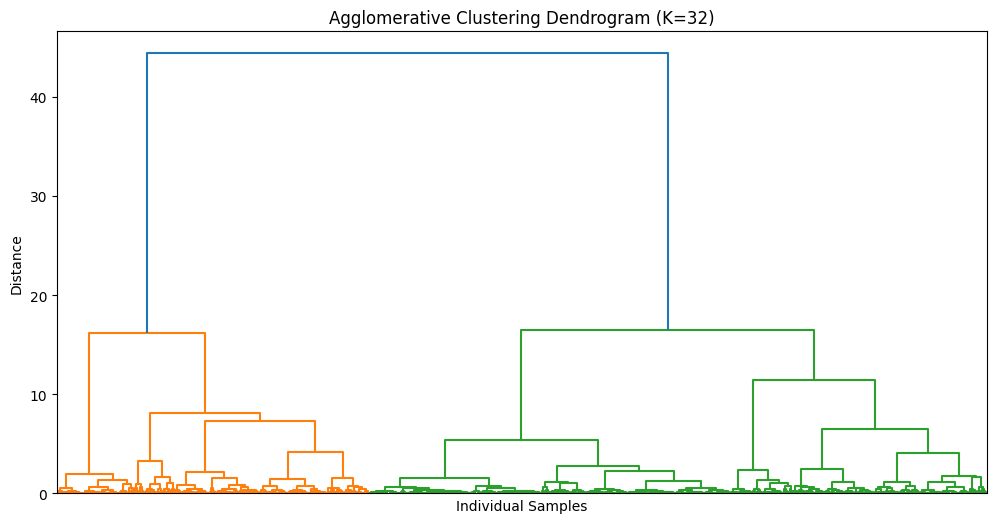

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
# Perform Agglomerative Clustering
k = 32
clustering = AgglomerativeClustering(n_clusters=k).fit(reshaped_image)
labels = clustering.labels_

# Calculate linkage matrix
linkage_matrix = linkage(reshaped_image.reshape(-1, 3), method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, orientation="top", no_labels=True)
plt.title("Agglomerative Clustering Dendrogram (K=32)")
plt.xlabel("Individual Samples")
plt.ylabel("Distance")
plt.show()

In [112]:
import numpy as np

X = [arr.flatten() for arr in nX]

# Convert X to a NumPy array
X = np.array(X)

# Perform Hierarchical Agglomerative Clustering
n_clusters = 32  # Set the number of clusters
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = agg_clustering.fit_predict(X)

# Plot the dendrogram for visualization
linked = linkage(X, method='ward')
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

# Print the cluster labels
print("Cluster labels:", cluster_labels)


**K-means Clustering**

In [ ]:
def initialize_centroids(data, k):
    num_samples = len(data)
    initial_indices = np.random.choice(num_samples, k, replace=False)
    initial_centroids = data[initial_indices]
    return initial_centroids

def custom_kmeans(data, k, initial_centroids, max_iterations=100):
    centroids = initial_centroids.copy()
    iterations = []
    centroid_changes = []
    for iteration in range(max_iterations):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        new_centroids = np.array([data[labels == i].mean(axis=0) if np.sum(labels == i) > 0 else centroids[i] for i in range(k)])
        iterations.append(iteration)
        centroid_changes.append(np.linalg.norm(centroids - new_centroids))  
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    return labels, centroids, iterations, centroid_changes


In [ ]:
ppm_img = imread("flowersm.ppm")

k_vals = [32,64,128,256]
reshaped_image = ppm_img.reshape(-1,3)
normalized_image = reshaped_image / 255.0

kmeans_rmse = []
kmeans_imgs = []
for k in k_vals:
    initial_centroids = initialize_centroids(normalized_image, k)
    labels, final_centroids, _, _ = custom_kmeans(normalized_image, k, initial_centroids)

    # Calculate RMSE
    distances = np.linalg.norm(normalized_image - final_centroids[labels], axis=1)
    mse = np.mean(distances ** 2)
    rmse = np.sqrt(mse)
    kmeans_rmse.append(rmse)

    clustered_image = final_centroids[labels]
    clustered_image = clustered_image.reshape(ppm_img.shape)
    clustered_image *= 255
    clustered_image = clustered_image.astype(np.uint8)
    kmeans_imgs.append(clustered_image)

C:\Users\conno\AppData\Local\Temp\ipykernel_2360\4209894561.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ppm_img = imread("flowersm.ppm")


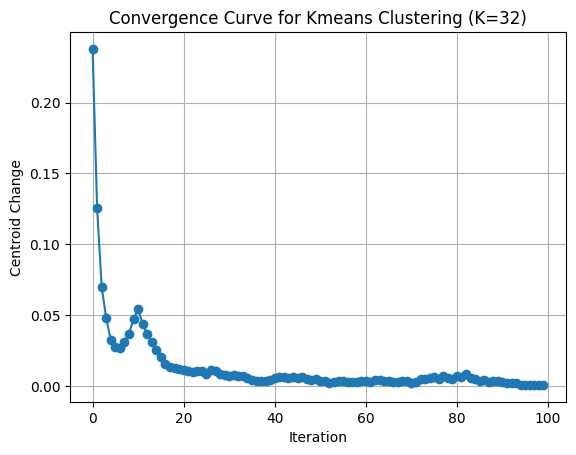

In [ ]:
initial_centroids = initialize_centroids(normalized_image, 32)
labels, final_centroids, iterations, centroid_changes = custom_kmeans(normalized_image, 32, initial_centroids)

plt.plot(iterations, centroid_changes, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Centroid Change')
plt.title('Convergence Curve for Kmeans Clustering (K=32)')
plt.grid(True)
plt.show()

**Winner Takes All Clustering**

In [ ]:
def wta_clustering(image, centroids, max_iterations=100):
    iteration_numbers = []
    centroid_changes = []
    
    for iteration in range(max_iterations):
        updated = False  # Flag to check if any centroid is updated in this iteration
        for i in range(image.shape[0]):
            # Calculate the distance between the current pixel and centroids
            distances = np.linalg.norm(image[i] - centroids, axis=1)
            
            # Find the index of the nearest centroid
            nearest_centroid = np.argmin(distances)
            
            # Check for empty clusters
            if np.sum(nearest_centroid == nearest_centroid) == 0:
                # If the nearest centroid is empty, replace it with the current pixel
                centroids[nearest_centroid] = image[i]
                updated = True
            else:
                # Update the centroid for the assigned cluster
                new_centroid = centroids[nearest_centroid] + (1 / (i + 1)) * (image[i] - centroids[nearest_centroid]) 
                if not np.array_equal(new_centroid, centroids[nearest_centroid]):
                    centroids[nearest_centroid] = new_centroid
                    updated = True

        # Calculate the change in centroids
        if iteration > 0:
            centroid_change = np.linalg.norm(centroids - previous_centroids)
            centroid_changes.append(centroid_change)
            iteration_numbers.append(iteration)
        
        # Check for convergence
        if not updated:
            break
        
        # Store the current centroids for the next iteration
        previous_centroids = centroids.copy()

    # Calculate labels based on the final centroids
    distances = np.linalg.norm(image[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)

    return labels, centroids, iteration_numbers, centroid_changes

def calculate_rmse(original_data, clustered_data):
    distances = np.linalg.norm(original_data - clustered_data, axis=1)
    mse = np.mean(distances ** 2)
    rmse = np.sqrt(mse)
    return rmse


In [ ]:
ppm_img = imread('flowersm.ppm')
reshaped_image = ppm_img.reshape(-1,3)
normalized_image = reshaped_image / 255.0

wta_images = []
wta_rmse = []
k_vals = [32, 64, 128, 256]

for k in k_vals:
    initial_centroids = normalized_image[np.random.choice(normalized_image.shape[0], k, replace=False)]
    labels, final_centroids, _, _ = wta_clustering(normalized_image, initial_centroids)

    # Calculate RMSE
    rmse = calculate_rmse(normalized_image, final_centroids[labels])
    wta_rmse.append(rmse)

    clustered_image = final_centroids[labels]
    clustered_image = clustered_image.reshape(ppm_img.shape)
    clustered_image *= 255
    clustered_image = clustered_image.astype(np.uint8)
    wta_images.append(clustered_image)

C:\Users\conno\AppData\Local\Temp\ipykernel_2360\637753186.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ppm_img = imread('flowersm.ppm')


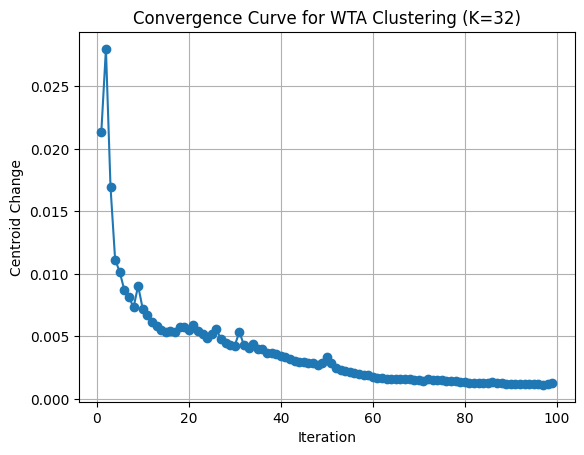

In [ ]:
initial_centroids = initialize_centroids(normalized_image, 32)
labels, final_centroids, iterations, centroid_changes = wta_clustering(normalized_image, initial_centroids)
plt.plot(iterations, centroid_changes, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Centroid Change')
plt.title('Convergence Curve for WTA Clustering (K=32)')
plt.grid(True)
plt.show()

**Create Clustering Images**

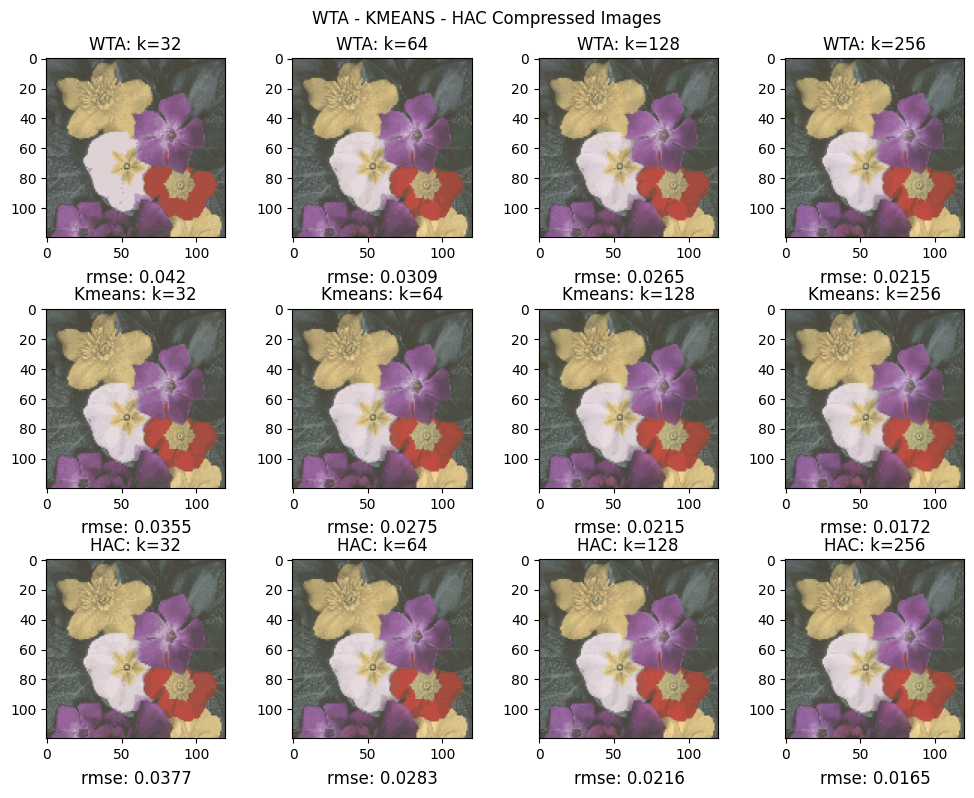

In [ ]:
def create_images():
    # Create a new figure and add subplots
    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
    plt.suptitle('WTA - KMEANS - HAC Compressed Images')

    # Plot the first image
    plt.subplot(3, 4, 1)  # 2 rows, 2 columns, first subplot
    plt.imshow(wta_images[0], cmap='viridis')
    plt.title('WTA: k=32')
    txt = "rmse: " + str(round(wta_rmse[0], 4))
    plt.text(60, 150, txt, fontsize=12, ha='center')

    # Plot the second image
    plt.subplot(3, 4, 2)  # 2 rows, 2 columns, second subplot
    plt.imshow(wta_images[1], cmap='viridis')
    plt.title('WTA: k=64')
    txt = "rmse: " + str(round(wta_rmse[1], 4))
    plt.text(60, 150, txt, fontsize=12, ha='center')

    # Plot the third image
    plt.subplot(3, 4, 3)  # 2 rows, 2 columns, third subplot
    plt.imshow(wta_images[2], cmap='viridis')
    plt.title('WTA: k=128')
    txt = "rmse: " + str(round(wta_rmse[2], 4))
    plt.text(60, 150, txt, fontsize=12, ha='center')
    
    # Plot the fourth image
    plt.subplot(3, 4, 4)  # 2 rows, 2 columns, fourth subplot
    plt.imshow(wta_images[3], cmap='viridis')
    plt.title('WTA: k=256')
    txt = "rmse: " + str(round(wta_rmse[3], 4))
    plt.text(60, 150, txt, fontsize=12, ha='center')
    
    # Plot the fifth image
    plt.subplot(3, 4, 5)  # 2 rows, 2 columns, first subplot
    plt.imshow(kmeans_imgs[0], cmap='viridis')
    plt.title('Kmeans: k=32')
    txt = "rmse: " + str(round(kmeans_rmse[0], 4))
    plt.text(60, 150, txt, fontsize=12, ha='center')
    
    # Plot the six image
    plt.subplot(3, 4, 6)  # 2 rows, 2 columns, second subplot
    plt.imshow(kmeans_imgs[1], cmap='viridis')
    plt.title('Kmeans: k=64')
    txt = "rmse: " + str(round(kmeans_rmse[1], 4))
    plt.text(60, 150, txt, fontsize=12, ha='center')
    
    # Plot the seventh image
    plt.subplot(3, 4, 7)  # 2 rows, 2 columns, third subplot
    plt.imshow(kmeans_imgs[2], cmap='viridis')
    plt.title('Kmeans: k=128')
    txt = "rmse: " + str(round(kmeans_rmse[2], 4))
    plt.text(60, 150, txt, fontsize=12, ha='center')
    
    # Plot the eigth image
    plt.subplot(3, 4, 8)  # 2 rows, 2 columns, fourth subplot
    plt.imshow(kmeans_imgs[3], cmap='viridis')
    plt.title('Kmeans: k=256')
    txt = "rmse: " + str(round(kmeans_rmse[3], 4))
    plt.text(60, 150, txt, fontsize=12, ha='center')
    
    # Plot the ninth image
    plt.subplot(3, 4, 9)  # 2 rows, 2 columns, first subplot
    plt.imshow(agg_imgs[0], cmap='viridis')
    plt.title('HAC: k=32')
    txt = "rmse: " + str(round(agg_rmse[0], 4))
    plt.text(60, 150, txt, fontsize=12, ha='center')
    
    # Plot the tenth image
    plt.subplot(3, 4, 10)  # 2 rows, 2 columns, second subplot
    plt.imshow(agg_imgs[1], cmap='viridis')
    plt.title('HAC: k=64')
    txt = "rmse: " + str(round(agg_rmse[1], 4))
    plt.text(60, 150, txt, fontsize=12, ha='center')
    
    # Plot the eleventh image
    plt.subplot(3, 4, 11)  # 2 rows, 2 columns, third subplot
    plt.imshow(agg_imgs[2], cmap='viridis')
    plt.title('HAC: k=128')
    txt = "rmse: " + str(round(agg_rmse[2], 4))
    plt.text(60, 150, txt, fontsize=12, ha='center')
    
    # Plot the twelfth image
    plt.subplot(3, 4, 12)  # 2 rows, 2 columns, fourth subplot
    plt.imshow(agg_imgs[3], cmap='viridis')
    plt.title('HAC: k=256')
    txt = "rmse: " + str(round(agg_rmse[3], 4))
    plt.text(60, 150, txt, fontsize=12, ha='center')
    
    plt.tight_layout()

    # Display the figure
    plt.show()
create_images()

In [110]:
import numpy as np

X = [arr.flatten() for arr in fX]

# Convert X to a NumPy array
X = np.array(X)

# Perform Winner Takes All (WTA) clustering with 32 clusters
n_clusters = 32
n_samples, n_features = X.shape

# Randomly initialize cluster centers
random_indices = np.random.choice(n_samples, n_clusters, replace=False)
centers = X[random_indices]

# Perform WTA clustering
labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centers, axis=2), axis=1)

# Calculate Inertia (WCSS) value for WTA clustering
inertia = np.sum(np.min(np.linalg.norm(X[:, np.newaxis] - centers, axis=2), axis=1) ** 2)
print("Inertia (WCSS) for WTA clustering:", inertia)


c:\Users\conno\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Inertia (WCSS) for WTA clustering: 17727560.0


In [92]:
class MED:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.Tr = train
        self.Te = test

    def fit(self, Tr, y):
        self.covs, self.means = {}, {}
        self.classes = np.unique(y)
        self.classn = len(self.classes)
        self.sigma = 0
        self.covsum_ = 0

        for c in self.classes:
            arr = Tr[y==int(c)]
            self.means[c] = ((1/len(arr)) * np.sum(arr[:], axis=0))
            self.covs[c] = np.cov(arr[:,:] - self.means[c], rowvar=False)
            i=0
            for covar in self.covs[c]:
                self.sigma += covar[i]
                i += 1
            
        self.sigma /= 4
    
    def predict(self, Te, prior):
        self.probs = []

        for i in range(0, len(Te)):
            #prob = []
            prob2 = []
            for c in self.means.keys():
                prob2.append(((-1)*(np.linalg.norm(self.means[c] - Te[i]))**2)/(2*self.sigma) * np.log(prior))
            self.probs.append(prob2)
    
    def evaluate(self, y):
        predicts = []
        correct, results = {}, {}
        correct['total'] = 0

        for i in range(0, len(self.probs)):
            predicts.append(np.argmax(self.probs[i]))
        
        for c in self.classes:
            correct[c] = 0
            for i in range(0, len(predicts)):
                if predicts[i] == y[i] and y[i] == c:
                    correct['total'] += 1
                    correct[c] += 1
            results[c] = 100*(correct[c]/np.count_nonzero(y[:] == c))
        results['total'] = 100*(correct['total']/len(predicts))

        return results

fnX = [arr.flatten() for arr in nX]
fx_test = [arr.flatten() for arr in tX]

MED_classifier = MED(train=np.array(tsne_TrX), test=np.array(tsne_TeX))

MED_classifier.fit(MED_classifier.Tr, y=np.array(y_train))

MED_classifier.predict(Te=MED_classifier.Te, prior=1/MED_classifier.classn)

res = MED_classifier.evaluate(y=np.array(y_train))
    
print(res)







{0: 11.43001857166976, 1: 3.604271729457134, 2: 0.13427324605572338, 3: 0.24465829391616375, 4: 0.15405682985279015, 5: 0.0, 6: 0.16897600540723218, 7: 0.6544293695131683, 8: 0.0, 9: 0.03361909564632712, 'total': 10.05}


In [ ]:
    # def bound_help(self, Te, prior):
    #     probs = []

    #     for i in range(0, len(Te)):
    #         prob = []
    #         for c in self.means.keys():
    #             prob.append(((-1)*(np.linalg.norm(self.means[c] - Te[i]))**2) / (2*self.sigma) + np.log(prior))
    #             probs.append(prob)

    #     temp = []
    #     for i in range(0, len(probs)):
    #         temp.append(probs[i])
        
    #     predicts = []
    #     correct, results = {}, {}
    #     correct['total'] = 0
        
    #     new = []
    #     for i in range(0, len(Te)):
    #         new.append(np.append(Te[i], np.argmax(probs[i])))
        
    #     return new